In [1]:
# 필요한 라이브러리 임포트
import os
import json
from PIL import Image, ExifTags, ImageOps
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras import regularizers
import matplotlib.pyplot as plt  # matplotlib 라이브러리 import

In [2]:
# 새로운 이미지 크기
new_size = (270, 480)

In [3]:
def preprocess_data(json_files, img_directory, new_size):  
    images = []  
    labels = []  

    for json_file in json_files:  
        with open(json_file, 'r') as f:  
            data = json.load(f)  

        img_file = data['imagePath']  
        img_path = os.path.join(img_directory, img_file)  

        img = Image.open(img_path)  
        img = ImageOps.exif_transpose(img)

        original_size = np.array(img).shape[:2]
        img = np.array(img)
        img = cv2.resize(img, new_size)  

        resize_ratio = (new_size[0] / original_size[1], new_size[1] / original_size[0])  # width, height
                
        for shape in data['shapes']:  
            if shape['label'] == 'tom_flower_poly':  
                points = np.array(shape['points'], np.float32)
                points[:, 0] *= resize_ratio[0]  # width
                points[:, 1] *= resize_ratio[1]  # height
                points = points.astype(np.int32)

                cv2.polylines(img, [points], True, (255, 255, 255), 1)  # 파란색 테두리 추가

        plt.imshow(img)  
        plt.title('Image with Polygons')  
        #plt.show() 이미지를 보고싶다면 주석을 제거 

        images.append(img)  
        labels.append(1 if len([shape for shape in data['shapes'] if shape['label'] == 'tom_flower_poly']) >= 3 else 0)  

    images = np.array(images)  
    labels = np.array(labels)  
    return images, labels

In [4]:
# 모델 생성 함수
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(new_size[1], new_size[0], 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    Dropout(0.5)
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    Dropout(0.5)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    Dropout(0.5)
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 데이터 디렉토리
directory = 'E:/tomato_label/097.지능형_스마트팜_통합_데이터(토마토)/01.데이터/1.Training/라벨링데이터/f.만개꽃'  
json_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.json')]
json_files = json_files[:3000]

img_directory = 'E:/tomato_label/097.지능형_스마트팜_통합_데이터(토마토)/01.데이터/1.Training/원천데이터/f.만개꽃/'  

In [ ]:
# 데이터 디렉토리 리스트
directories = ['E:/tomato_label/097.지능형_스마트팜_통합_데이터(토마토)/01.데이터/1.Training/라벨링데이터/f.만개꽃',
               'E:/tomato_label/097.지능형_스마트팜_통합_데이터(토마토)/01.데이터/1.Training/라벨링데이터/d1.꽃(개화군)']

# 각 디렉토리에서 JSON 파일 불러오기
json_files = []
for directory in directories:
    json_files.extend([os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.json')])

# 이미지 디렉토리 리스트
img_directories = ['E:/tomato_label/097.지능형_스마트팜_통합_데이터(토마토)/01.데이터/1.Training/원천데이터/f.만개꽃',
                   'E:/tomato_label/097.지능형_스마트팜_통합_데이터(토마토)/01.데이터/1.Training/원천데이터/d1.꽃(개화군)']

# 각 디렉토리에서 이미지 파일 불러오기
img_files = []
for img_directory in img_directories:
    img_files.extend([os.path.join(img_directory, file) for file in os.listdir(img_directory) if file.endswith('.jpg')])

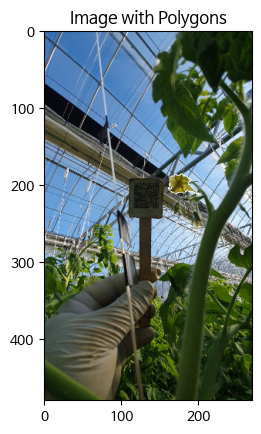

In [6]:
# 데이터 전처리
images, labels = preprocess_data(json_files, img_directory, new_size)

# 데이터 분할
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.4, random_state=42)

In [7]:
# 모델 생성
model = create_model()

In [8]:
# 모델 학습
model.fit(train_images, train_labels, epochs=3, batch_size=32, validation_data=(test_images, test_labels))

# 라벨별 데이터 개수 출력
unique, counts = np.unique(labels, return_counts=True)
label_counts = dict(zip(unique, counts))

for label, count in label_counts.items():
    print(f"Label {label}: {count}개")

Epoch 1/3


28/28 [==============================] - 44s 2s/step - loss: 1042.7635 - accuracy: 0.7268 - val_loss: 2.7088 - val_accuracy: 0.7772
Epoch 2/3
28/28 [==============================] - 43s 2s/step - loss: 0.5975 - accuracy: 0.8696 - val_loss: 0.9043 - val_accuracy: 0.7789
Epoch 3/3
28/28 [==============================] - 41s 1s/step - loss: 0.0377 - accuracy: 0.9921 - val_loss: 1.0983 - val_accuracy: 0.7908
Label 0: 1205개
Label 1: 265개


In [9]:
# 테스트 데이터 전처리 함수

def preprocess_test_images(directory, new_size):
    images = []
    labels = []

    for root, dirs, files in os.walk(directory):
        for img_file in files:
            img_path = os.path.join(root, img_file)
            
            img = Image.open(img_path)

            # 원본 이미지의 가로 세로 비율 계산
            ratio = img.width / img.height

            # 원본 비율을 유지하면서 세로축을 기준으로 축소할 크기 계산
            resize_size = (int(new_size[1] * ratio), new_size[1])

            # 원본 이미지를 적절하게 축소
            img = img.resize(resize_size)

            # 축소된 이미지를 원하는 최종 크기로 잘라내기
            left = (img.size[0] - new_size[0]) / 2
            right = (img.size[0] + new_size[0]) / 2

            img = img.crop((left, 0, right, new_size[1]))

            img = img.rotate(270)

            img = np.array(img)

            images.append(img)

            if "blossomed_3" in root:
                labels.append(1)
            else:
                labels.append(0)
    
    return np.array(images, dtype=object), np.array(labels)


In [ ]:
# 테스트 데이터 전처리
blossomed_3_directory = "E:\\tomato_data\\TOMATO_BLOOMING_IMAGE_ENV_20231124\\TOMATO_BLOOMING_IMAGE_ENV_20231124\\blossomed_3"
blossomed_2_directory = "E:\\tomato_data\\TOMATO_BLOOMING_IMAGE_ENV_20231124\\TOMATO_BLOOMING_IMAGE_ENV_20231124\\blossomed_2"
blossomed_1_directory = "E:\\tomato_data\\TOMATO_BLOOMING_IMAGE_ENV_20231124\\TOMATO_BLOOMING_IMAGE_ENV_20231124\\blossomed_1"

test_images_3, test_labels_3 = preprocess_test_images(blossomed_3_directory, new_size)
test_images_2, test_labels_2 = preprocess_test_images(blossomed_2_directory, new_size)
test_images_1, test_labels_1 = preprocess_test_images(blossomed_1_directory, new_size)

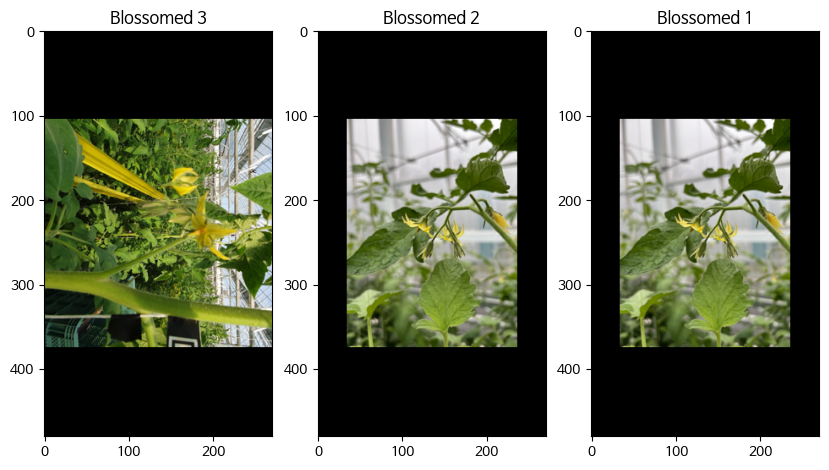

In [13]:
# 테스트 데이터가 전처리가 잘 됐는지 확인하는 코드
# 보고싶은 이미지 출력

plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.title('Blossomed 3')
test_images_3_float32 = np.array(test_images_3, dtype=np.float32) / 255.0
plt.imshow(test_images_3_float32[110])

plt.subplot(1, 3, 2)
plt.title('Blossomed 2')
test_images_2_float32 = np.array(test_images_2, dtype=np.float32) / 255.0
plt.imshow(test_images_2_float32[0])

plt.subplot(1, 3, 3)
plt.title('Blossomed 1')
test_images_1_float32 = np.array(test_images_2, dtype=np.float32) / 255.0
plt.imshow(test_images_1_float32[0])

plt.show()

In [14]:
# 모델 예측
predictions_3 = model.predict(test_images_3_float32)
predictions_2 = model.predict(test_images_2_float32)
predictions_1 = model.predict(test_images_1_float32)

23/23 [==============================] - 5s 198ms/step


In [15]:
# 예측 결과를 이진 값으로 변환
predictions_3_binary = (predictions_3 > 0.5).astype("int32")
predictions_2_binary = (predictions_2 > 0.5).astype("int32")
predictions_1_binary = (predictions_1 > 0.5).astype("int32")

In [ ]:
# 예측 결과 출력
print("Predictions for 'blossomed_3' images:")
for i, prediction in enumerate(predictions_3_binary):
    print(f"Image {i+1}: {'Blossomed' if prediction == 1 else 'Not blossomed'}")
    
print("Predictions for 'blossomed_2' images:")
for i, prediction in enumerate(predictions_2_binary):
    print(f"Image {i+1}: {'Blossomed' if prediction == 1 else 'Not blossomed'}")

print("\nPredictions for 'blossomed_1' images:")
for i, prediction in enumerate(predictions_1_binary):
    print(f"Image {i+1}: {'Blossomed' if prediction == 1 else 'Not blossomed'}")

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Confusion matrix 
cm_3 = confusion_matrix(test_labels_3, predictions_3_binary)
cm_2 = confusion_matrix(test_labels_2, predictions_2_binary)
cm_1 = confusion_matrix(test_labels_1, predictions_1_binary)

print("Confusion matrix for 'blossomed_3' images:")
print(cm_3)

print("\nConfusion matrix for 'blossomed_2' images:")
print(cm_2)

print("\nConfusion matrix for 'blossomed_1' images:")
print(cm_1)

# Accuracy
accuracy_3 = accuracy_score(test_labels_3, predictions_3_binary)
accuracy_2 = accuracy_score(test_labels_2, predictions_2_binary)
accuracy_1 = accuracy_score(test_labels_1, predictions_1_binary)

print(f"\nAccuracy for 'blossomed_3' images: {accuracy_3*100:.2f}%")
print(f"\nAccuracy for 'blossomed_2' images: {accuracy_2*100:.2f}%")
print(f"\nAccuracy for 'blossomed_1' images: {accuracy_1*100:.2f}%")

# Precision
precision_3 = precision_score(test_labels_3, predictions_3_binary)
precision_2 = precision_score(test_labels_2, predictions_2_binary)
precision_1 = precision_score(test_labels_1, predictions_1_binary)

print(f"\nPrecision for 'blossomed_3' images: {precision_3*100:.2f}%")
print(f"\nPrecision for 'blossomed_2' images: {precision_2*100:.2f}%")
print(f"\nPrecision for 'blossomed_1' images: {precision_1*100:.2f}%")

# Recall
recall_3 = recall_score(test_labels_3, predictions_3_binary)
recall_2 = recall_score(test_labels_2, predictions_2_binary)
recall_1 = recall_score(test_labels_1, predictions_1_binary)

print(f"\nRecall for 'blossomed_3' images: {recall_3*100:.2f}%")
print(f"\nRecall for 'blossomed_2' images: {recall_2*100:.2f}%")
print(f"\nRecall for 'blossomed_1' images: {recall_1*100:.2f}%")

ValueError: Found input variables with inconsistent numbers of samples: [769, 732]